# **Setup**

Install dependencies

In [ ]:
# Database imports
from itertools import islice
from sortedcontainers import SortedDict

from __future__ import (absolute_import, division, print_function)

# Image imports
import os
from PIL import Image, ImageFilter

# Model prediction imports
import numpy as np
import math


Upload dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# You will need the BAYCArchive.zip in your google drive
# This will unzip it and put it in the colab files
!unzip -uq "/content/drive/My Drive/BAYC/BAYCArchive.zip" -d "/content/BAYC"

Mounted at /content/drive


Iterate through the dataset and create an image array

In [ ]:
from os import listdir

folder_dir = "/content/BAYC/bayc"
temp = folder_dir[:] + '/'

In [ ]:
imgArr = []
stringArr = []

for image in os.listdir(folder_dir):
  dir = temp + str(image)
  if (dir == '/content/BAYC/bayc/hashes.csv'): #skip the csv file
    continue
  # print(dir) it actually works lfg
  image = Image.open(dir)
  # display(image) this also works lfg
  imgArr.append(image)
  stringArr.append(dir)

Unpickle the machine learning model

In [ ]:
import pickle

The main functions of `pickle` are:

* `dump()`: pickles data by accepting data and a file object.
* `load()`: takes a file object, reconstruct the objects from the pickled representation, and returns it.
* `dumps()`: returns the pickled data as a string.
* `loads()`: reads the pickled data from a string.

`dump()`/`load()` serializes/deserializes objects through files but `dumps()`/`loads()` serializes/deserializes objects through string representation.

In [ ]:
with open('/content/model (2).pkl', 'rb') as fid:
     model = pickle.load(fid)

# **Hashing**

Install dependencies
- Pillow (general image enhancement package for python)
- Image (a module from pillow that allows for image hashing)

In [ ]:
def _binary_array_to_hex(arr):
	"""
	internal function to make a hex string out of a binary array.
	"""
	bit_string = ''.join(str(b) for b in 1 * arr.flatten())
	width = int(numpy.ceil(len(bit_string)/4))
	return '{:0>{width}x}'.format(int(bit_string, 2), width=width)


class ImageHash(object):
	"""
	Hash encapsulation. Can be used for dictionary keys and comparisons.
	"""
	def __init__(self, binary_array):
		self.hash = binary_array

	def __str__(self):
		return _binary_array_to_hex(self.hash.flatten())

	def __repr__(self):
		return repr(self.hash)

	def __sub__(self, other):
		if other is None:
			raise TypeError('Other hash must not be None.')
		if self.hash.size != other.hash.size:
			raise TypeError('ImageHashes must be of the same shape.', self.hash.shape, other.hash.shape)
		return numpy.count_nonzero(self.hash.flatten() != other.hash.flatten())

	def __eq__(self, other):
		if other is None:
			return False
		return numpy.array_equal(self.hash.flatten(), other.hash.flatten())

	def __ne__(self, other):
		if other is None:
			return False
		return not numpy.array_equal(self.hash.flatten(), other.hash.flatten())

	def __hash__(self):
		# this returns a 8 bit integer, intentionally shortening the information
		return sum([2**(i % 8) for i, v in enumerate(self.hash.flatten()) if v])

	def __len__(self):
		# Returns the bit length of the hash
		return self.hash.size



def phash(image, hash_size=8, highfreq_factor=4):
	"""
	Perceptual Hash computation.
	Implementation follows http://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html
	@image must be a PIL instance.
	"""
	if hash_size < 2:
		raise ValueError("Hash size must be greater than or equal to 2")

	import scipy.fftpack
	img_size = hash_size * highfreq_factor
	image = image.convert("L").resize((img_size, img_size), Image.ANTIALIAS)
	pixels = numpy.asarray(image)
	dct = scipy.fftpack.dct(scipy.fftpack.dct(pixels, axis=0), axis=1)
	dctlowfreq = dct[:hash_size, :hash_size]
	med = numpy.median(dctlowfreq)
	diff = dctlowfreq > med
	return ImageHash(diff)


In [ ]:
"""
Copyright (c) 2013-2020, Johannes Buchner
https://github.com/JohannesBuchner/imagehash
All rights reserved.
"""

'\nCopyright (c) 2013-2020, Johannes Buchner\nhttps://github.com/JohannesBuchner/imagehash\nAll rights reserved.\n'

# **Clean, Hash, and Image Conversion**

In [ ]:
from __future__ import (absolute_import, division, print_function)

import tensorflow as tf
import os

from PIL import Image, ImageFilter
import numpy

In [ ]:
def cleanAndHash(image, height, width):
  hash = str(phash(image))
  image = image.convert("L").resize((height, width))
  return image, hash

# **DB Functions**

In [ ]:
def closest(sorted_dict, key):
    "Return closest key in `sorted_dict` to given `key`."
    assert len(sorted_dict) > 0
    keys = list(islice(sorted_dict.irange(minimum=key), 1))
    keys.extend(islice(sorted_dict.irange(maximum=key, reverse=True), 1))
    return min(keys, key=lambda k: abs(key - k))

def hashToKey(hash):
  "Convert a hex string to a key that can be used in a hashmap"
  hash = str(hash)
  hash = hash[3:]
  key = int(hash, 16)
  return key

def createDB(images, addresses):
  "Index through a list of images, clean and hash each image,"
  "Add each image and its hash to the database"
  db = SortedDict()
  i = 0
  for image in images:
    image, hashList = cleanAndHash(image, 80, 80)
    key = hashToKey(hashList)
    try:
      db[key]
      db[key] += [addresses[i]]
    except:
      db[key] = [addresses[i]]
    i += 1
  return db

def getClosestImage(image, db):
  image, hashList = cleanAndHash(image, 80, 80)
  hash = hashToKey(hashList)
  try:
    db[hash]
    return db[hash]
  except:
    return db[closest(db, hash)]

# **ML Model Functions**

In [ ]:
def mlpredict(imgAddress):
  img = tf.keras.utils.load_img(
    imgAddress, target_size=(631, 631)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  maxInd = 0
  max = -1
  ind = 0
  for sco in score:
    if sco > max:
      max = sco
      maxInd = ind
    ind += 1

  classes = ["Azuki", "Bored Ape", "CloneX", "CryptoPunk", "MoonBird"]
  if classes[maxInd] != "Bored Ape":
    return "None"
  return classes[maxInd]

Finding the mean, highest, lowest standard deviation of a collection of images

# **Duplicate Detection**

In [ ]:
from tensorflow.python.platform.tf_logging import info
# Takes in an image addres (Ex: '/content/Military_7050.png') and returns the
# original Bored Ape, if there is one

def getDuplicate(imageAddr, database):
  className = mlpredict(imageAddr)
  if className == "None":
    print("This image is not a Bored Ape")
    return 
  img = Image.open(imageAddr)
  duplicates = getClosestImage(img, database)
  if len(duplicates) == 1:
    print("The input image is a derivative of the following Bored Ape:")
  else:
    print("The input image is a derivative of one of the following Bored Apes:")
  for image in duplicates:
    display(Image.open(image).resize((200,200)))
  return 


# **Create Bored Ape Database**

In [ ]:
fullDB = createDB(imgArr, stringArr)

# **Tests**

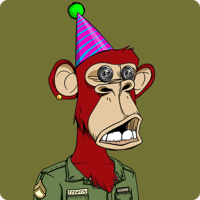

The input image is a derivative of the following Bored Ape:


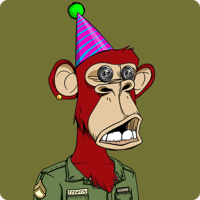

In [ ]:
imgAddr = '/content/Military.png'
img = Image.open(imgAddr).resize((200,200))
display(img)
getDuplicate(imgAddr, fullDB)